In [1]:
import time
a = time.time()

In [1]:
import os
import json 
import subprocess
import importlib
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe

import xbitinfo as xb
import xarray as xr

/home/datacomp/miniconda3/envs/bitinfo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

---

In [3]:
path_to_data = '../data/netcdf/ecmwf_hs3g_20181101_dsrp.nc'  # change this
ds = xr.open_dataset(path_to_data)

In [4]:
ds = ds.sel({'longitude': ds.longitude[::],
                   'latitude': ds.latitude[:12000]
                  })

In [5]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 24000, latitude: 12000, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.015 0.03 0.045 ... 360.0 360.0 360.0
  * latitude   (latitude) float32 90.0 89.99 89.97 ... -89.96 -89.97 -89.99
  * time       (time) datetime64[ns] 2018-11-01T18:00:00
Data variables:
    dsrp       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-23 10:23:52 GMT by grib_to_netcdf-2.30.2: grib_to_n...

In [6]:
# get information content per bit
info_per_bit = xb.get_bitinformation(ds, dim="latitude",
                                     # implementation="python"
                                    )

Processing var: dsrp for dim: latitude: 100%|█████████████████████| 1/1 [00:49<00:00, 49.23s/it]


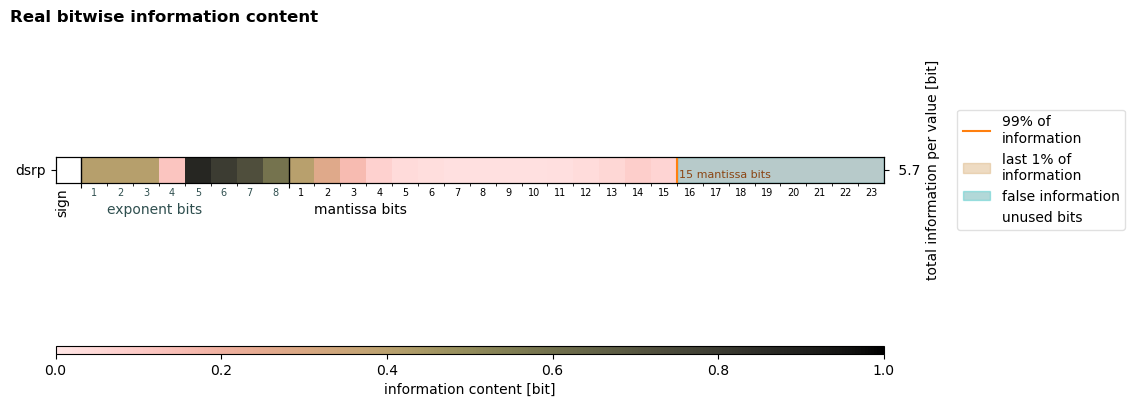

In [7]:
fig = xb.plot_bitinformation(info_per_bit)

In [13]:
# get keepbits
keepbits = xb.get_keepbits(info_per_bit, 0.99)
keepbits

<xarray.Dataset>
Dimensions:   (inflevel: 1)
Coordinates:
    dim       <U8 'latitude'
  * inflevel  (inflevel) float64 0.99
Data variables:
    dsrp      (inflevel) int64 15

In [17]:
# apply bitrounding 15 kb
ds_bitrounded_99p = xb.xr_bitround(ds, keepbits)
# apply bitrounding min = 0kb
ds_bitrounded_3 = xb.xr_bitround(ds, 3)

In [18]:
ds_bitrounded_3.to_compressed_netcdf("bitrounded_compressed_3.nc")
ds_bitrounded_99p.to_compressed_netcdf("bitrounded_compressed_99p.nc")

In [ ]:
ds.to_compressed_netcdf("compressed.nc")

In [19]:
ds.to_netcdf("original.nc")

---

In [22]:
at_least_zero = lambda x: [max(y, 0) for y in x]

chunk_long, chunk_lat = [800, 400] # for int division
vrbs = ['longitude', 'latitude']
var = 'latitude'

dss = []
dss_bitrounded = []
dss_kbits = []

long_c = int(ds.longitude.size / chunk_long)
lat_c = int(ds.latitude.size / chunk_lat)


for i in range(long_c):
    for j in range(lat_c):
        temp_ds = ds.isel(longitude=slice(i*chunk_long, (i+1)*chunk_long),
                          latitude=slice(j*chunk_lat, (j+1)*chunk_lat))
        dss.append(temp_ds)
        
        temp_info_pbit = xb.get_bitinformation(temp_ds, dim=var, implementation="python")
        
        temp_keepbits = xb.get_keepbits(temp_info_pbit, 0.99)
        var_kp = list(temp_keepbits.keys())[0]
        # cope with negative keepbits
        temp_keepbits[var_kp].data = at_least_zero(temp_keepbits[var_kp].data)
        dss_kbits.append(temp_keepbits)
        
        temp_ds_bitrounded = xb.xr_bitround(temp_ds, temp_keepbits)
        dss_bitrounded.append(temp_ds_bitrounded)

        if i == 0 and j == 0 : 
            MERGED_ds_bitr = temp_ds_bitrounded
        else:
            MERGED_ds_bitr = xr.merge([MERGED_ds_bitr, temp_ds_bitrounded])

Processing var: dsrp for dim: latitude: 100%|█████████████████████| 1/1 [00:00<00:00,  3.63it/s]


In [23]:
MERGED_ds_bitr.to_compressed_netcdf("bitrounded_compressed_merged_chunks.nc")

---

In [9]:
variables = list(ds.keys())
variables

['dsrp']

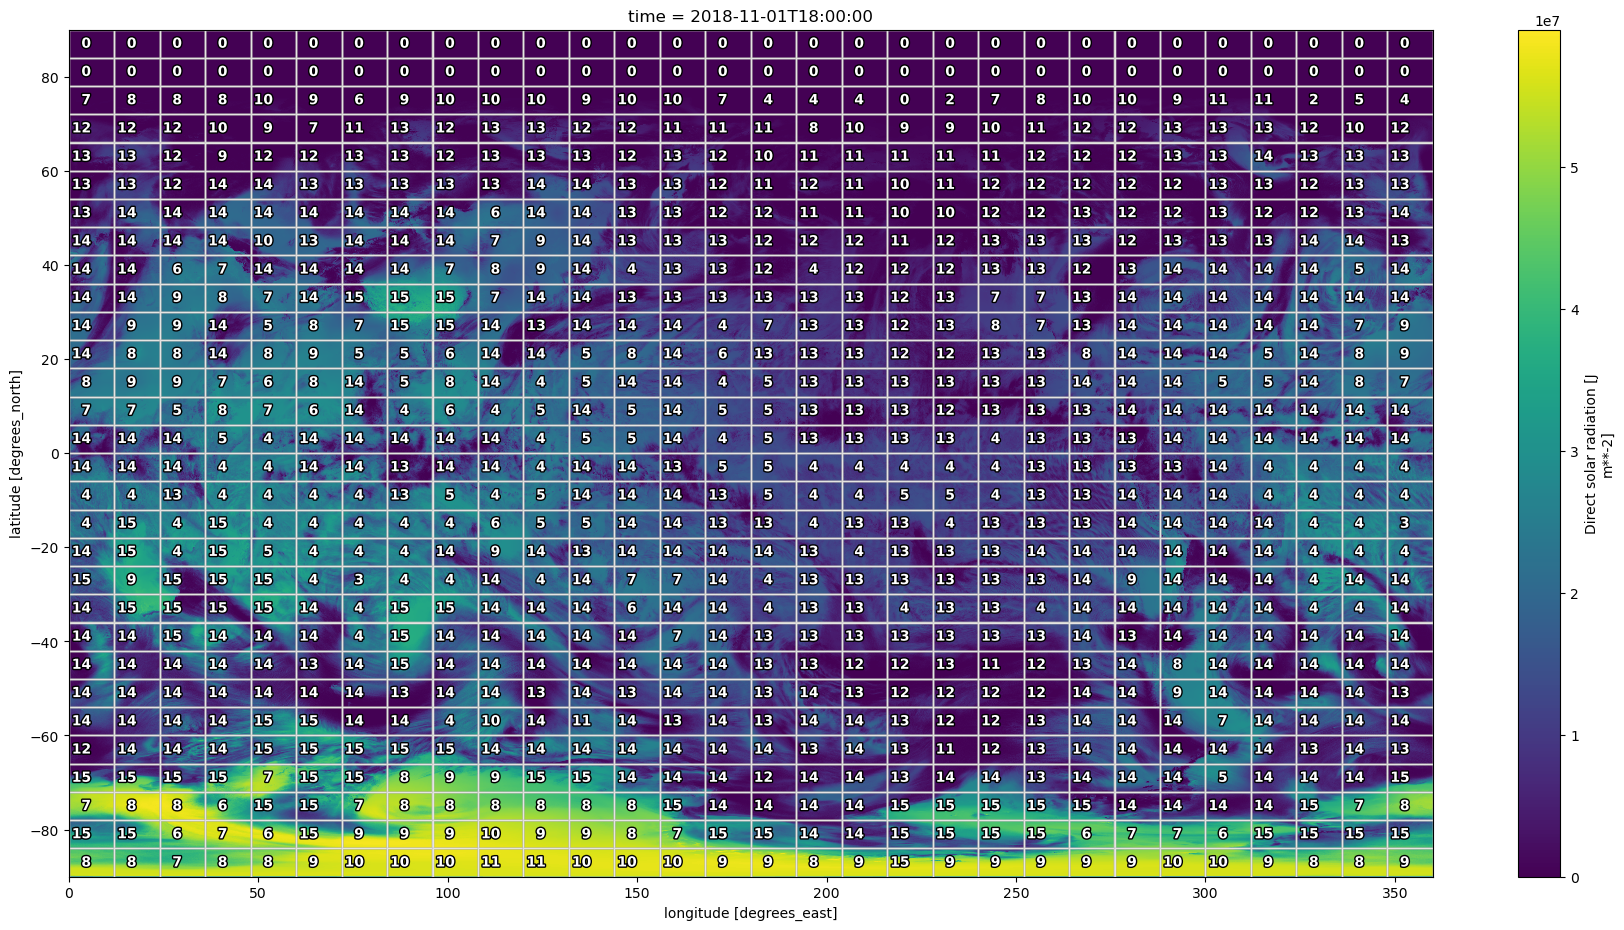

In [10]:
for v in variables:
    fig, ax = plt.subplots(figsize=(22, 11))
        
    ds[v].plot(ax=ax)

    for i in range(len(dss_bitrounded)):
        x = float(min(dss[i].longitude[0], dss[i].longitude[-1]))
        y = float(min(dss[i].latitude[0], dss[i].latitude[-1]))
        w = float(abs(dss[i].longitude[0] - dss[i].longitude[-1]))
        h = float(abs(dss[i].latitude[0] - dss[i].latitude[-1]))
        rect = mpl.patches.Rectangle((x, y), width = w, height = h,
                                    facecolor = "none", edgecolor = "#E5E4E2",
                                    path_effects=[pe.withStroke(linewidth=1, foreground="gray")],
                                    label='xxx')
        ax.add_patch(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0
        ax.annotate(
            f"""
            {int(dss_kbits[i][v]):2}
            """,
            (cx, cy), color='w', weight='bold', fontsize=10, ha='right', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='k')]
        )

    fig.show()

In [11]:
data = [[int(i) for i in list(dss_kbits[j].to_array().data)] for j in range(len(dss_kbits))]
variables = list(ds.keys())

df = pd.DataFrame(data=data,
                  columns=variables)
df.head()              

/tmp/ipykernel_11720/4235891130.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = [[int(i) for i in list(dss_kbits[j].to_array().data)] for j in range(len(dss_kbits))]
/tmp/ipykernel_11720/4235891130.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = [[int(i) for i in list(dss_kbits[j].to_array().data)] for j in range(len(dss_kbits))]
/tmp/ipykernel_11720/4235891130.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = [[int(i) for i in list(d

,dsrp
0,0
1,0
2,7
3,12
4,13


In [12]:
df.describe()

,dsrp
count,900.000000
mean,10.545556
std,4.452834
min,0.000000
25%,8.000000
50%,13.000000
75%,14.000000
max,15.000000


---

In [24]:
!du -hs *.nc

20M	bitrounded_compressed_0.nc
61M	bitrounded_compressed_3.nc
351M	bitrounded_compressed_99p.nc
292M	bitrounded_compressed_merged_chunks.nc
1.1G	original.nc


In [25]:
!rm *.nc

In [26]:
du_output = """20M	bitrounded_compressed_0.nc
61M	bitrounded_compressed_3.nc
351M	bitrounded_compressed_99p.nc
292M	bitrounded_compressed_merged_chunks.nc
1.1G	original.nc
"""
du_output

'20M\tbitrounded_compressed_0.nc\n61M\tbitrounded_compressed_3.nc\n351M\tbitrounded_compressed_99p.nc\n292M\tbitrounded_compressed_merged_chunks.nc\n1.1G\toriginal.nc\n'

In [32]:
def convert_to_bytes(size_str):
    multipliers = {'K': 1e3, 'M': 1e6, 'G': 1e9, 'T': 1e12}  # Define multipliers for different units
    unit = size_str[-1]
    size = float(size_str[:-1])
    return size * multipliers[unit]

dict_sizes = {}

for line in du_output.splitlines():
    size, name = line.split('\t')
    dict_sizes[name] = convert_to_bytes(size)

dict_sizes

{'bitrounded_compressed_0.nc': 20000000.0,
 'bitrounded_compressed_3.nc': 61000000.0,
 'bitrounded_compressed_99p.nc': 351000000.0,
 'bitrounded_compressed_merged_chunks.nc': 292000000.0,
 'original.nc': 1100000000.0}

In [33]:
dict_sizes_ori = {}
for line in du_output.splitlines():
    size, name = line.split('\t')
    dict_sizes_ori[name] = size

dict_sizes_ori

{'bitrounded_compressed_0.nc': '20M',
 'bitrounded_compressed_3.nc': '61M',
 'bitrounded_compressed_99p.nc': '351M',
 'bitrounded_compressed_merged_chunks.nc': '292M',
 'original.nc': '1.1G'}

In [28]:
def sort_dict_by_values(d):
    sorted_items = sorted(d.items(), key=lambda item: item[1])
    return dict(sorted_items)

sorted_dict = sort_dict_by_values(dict_sizes)

In [48]:
sorted_dict_2 = {}
for k in sorted_dict.keys():
    sorted_dict_2[k] = dict_sizes_ori[k]    

In [49]:
sorted_dict_2

{'bitrounded_compressed_0.nc': '20M',
 'bitrounded_compressed_3.nc': '61M',
 'bitrounded_compressed_merged_chunks.nc': '292M',
 'bitrounded_compressed_99p.nc': '351M',
 'original.nc': '1.1G'}

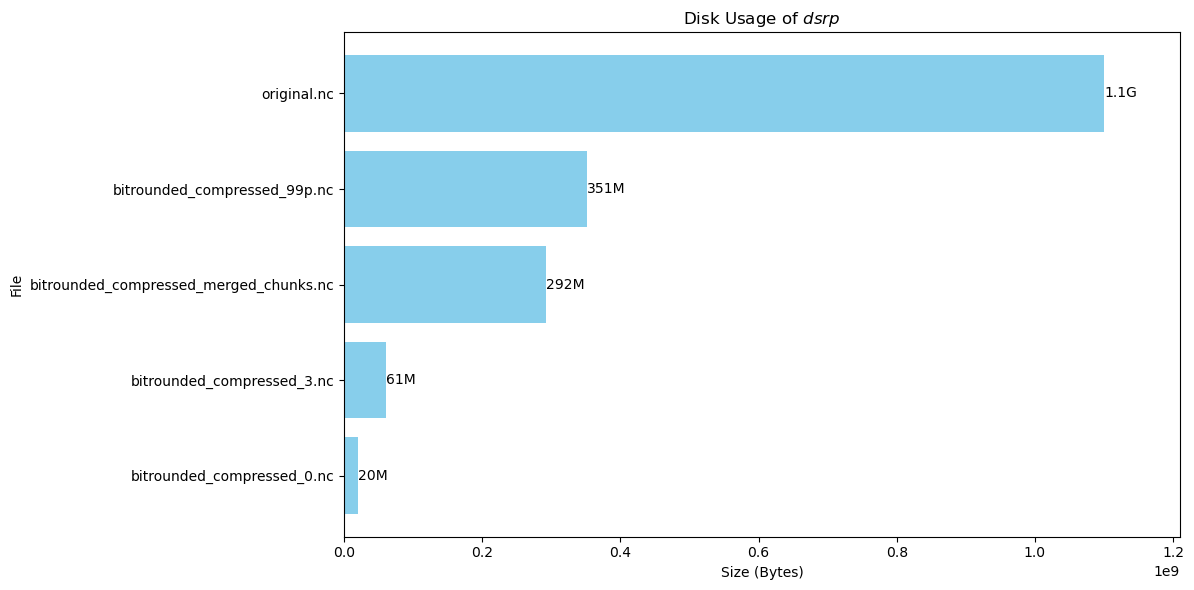

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(list(sorted_dict.keys()), list(sorted_dict.values()), color='skyblue')
ax.bar_label(bars, labels=sorted_dict_2.values())

ax.set_xlabel('Size (Bytes)')
ax.set_ylabel('File')
ax.set_title(f'Disk Usage of ${variables[0]}$')
plt.tight_layout()

ax.set_xlim(right=max(sorted_dict.values())*1.1)
plt.show()

In [ ]:
b = time.time()

def format_seconds(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    remaining_seconds = seconds % 60

    time_string = f"{hours:02d}:{minutes:02d}:{remaining_seconds:02d}"
    return time_string


# Test the function
seconds_input = 3672
formatted_time = format_seconds(seconds_input)
print(f"{seconds_input} seconds is {formatted_time}")
